In [44]:
from typing import TypeAlias, TypeVar, Protocol
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.figure import Figure
from matplotlib.axes import Axes

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Type aliases
ArrayLike: TypeAlias = np.ndarray
DatasetType: TypeAlias = tuple[ArrayLike, ArrayLike, str]

# Define a protocol for classifiers
class ClassifierProtocol(Protocol):
    def fit(self, X: ArrayLike, y: ArrayLike) -> 'ClassifierProtocol':
        ...
    
    def predict(self, X: ArrayLike) -> ArrayLike:
        ...

    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        ...
    
    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        ...

T = TypeVar('T', bound=ClassifierProtocol)

class MultiClassWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, clf: T) -> None:
        self.clf = clf

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'MultiClassWrapper':
        self.classes_ = np.unique(y)
        self.clf.fit(X, y)
        return self

    def predict(self, X: ArrayLike) -> ArrayLike:
        return self.clf.predict(X)

    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        if hasattr(self.clf, "predict_proba"):
            return self.clf.predict_proba(X)
        else:
            # If the classifier doesn't have predict_proba, use decision_function
            df = self.clf.decision_function(X)
            if df.ndim == 1:
                return np.column_stack([1 / (1 + np.exp(-df)), 1 / (1 + np.exp(df))])
            else:
                return np.exp(df) / np.sum(np.exp(df), axis=1)[:, np.newaxis]

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return self.clf.score(X, y)

def plot_classifier_comparison(
    classifiers: dict[str, ClassifierProtocol],
    datasets: list[DatasetType]
) -> Figure:
    # Use Fira Sans as the font
    plt.rcParams['font.family'] = 'Fira Sans'

    # Define a modern color palette
    color_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#20B2AA', '#87CEFA']
    cm_bright = ListedColormap(color_palette)

    n_classifiers = len(classifiers)
    n_datasets = len(datasets)
    
    # Set a fixed figure size and adjust subplot parameters
    fig_width = 2.7 * (n_classifiers + 1)
    fig_height = 2.5 * n_datasets
    fig, axes = plt.subplots(n_datasets, n_classifiers + 1, 
                             figsize=(fig_width, fig_height),
                             squeeze=False)

    # Set consistent aspect ratio for all subplots
    aspect_ratio = 1.0

    # iterate over datasets
    for ds_cnt, (X, y, ds_name) in enumerate(datasets):
        X = X[:, :2]
        
        # preprocess dataset, split into training and test part
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )
        print(f"\nProcessing dataset: {ds_name}")

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # Adjust the limits to maintain the aspect ratio
        x_range = x_max - x_min
        y_range = y_max - y_min
        if x_range > y_range:
            y_center = (y_max + y_min) / 2
            y_min = y_center - x_range / 2
            y_max = y_center + x_range / 2
        else:
            x_center = (x_max + x_min) / 2
            x_min = x_center - y_range / 2
            x_max = x_center + y_range / 2

        # just plot the dataset first
        ax = axes[ds_cnt, 0]
        scatter_plot = plot_dataset(ax, X_train, y_train, X_test, y_test, ds_name, x_min, x_max, y_min, y_max, cm_bright, ds_cnt == 0)
        ax.set_aspect(aspect_ratio)

        # iterate over classifiers
        for clf_cnt, (name, clf) in enumerate(classifiers.items()):
            ax = axes[ds_cnt, clf_cnt + 1]
            plot_classifier(ax, clf, X_train, y_train, X_test, y_test, x_min, x_max, y_min, y_max, cm_bright, scatter_plot, name, ds_cnt == 0)
            ax.set_aspect(aspect_ratio)
    # Add grid lines between plots
    for i in range(1, n_datasets):
        plt.axhline(y=i/n_datasets, color='#D3D3D3', linestyle='-', linewidth=0.5)
    for i in range(1, n_classifiers + 1):
        plt.axvline(x=i/(n_classifiers + 1), color='#D3D3D3', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    return fig

def plot_dataset(
    ax: Axes,
    X_train: ArrayLike,
    y_train: ArrayLike,
    X_test: ArrayLike,
    y_test: ArrayLike,
    ds_name: str,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    cm_bright: ListedColormap,
    is_first: bool
) -> plt.scatter:
    if is_first:
        ax.set_title("Input data")
    # Plot the training points
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    # Remove frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add dataset name
    ax.text(x_min + 0.5, y_min + 0.5, ds_name, fontsize=10, verticalalignment='top')
    # Add legend
    ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
    return scatter

def plot_classifier(
    ax: Axes,
    clf: ClassifierProtocol,
    X_train: ArrayLike,
    y_train: ArrayLike,
    X_test: ArrayLike,
    y_test: ArrayLike,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    cm_bright: ListedColormap,
    scatter_plot: plt.scatter,
    name: str,
    is_first: bool
) -> None:
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary with probabilities
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    # Get unique classes and their corresponding colors from the scatter plot
    unique_classes = np.unique(np.concatenate((y_train, y_test)))
    n_classes = len(unique_classes)
    class_colors = [cm_bright(scatter_plot.norm(cl)) for cl in unique_classes]

    # For multi-class, blend the probabilities
    Z_rgb = np.zeros((Z.shape[0], 4))  # RGBA
    for i, color in enumerate(class_colors):
        Z_rgb[:, :3] += Z[:, i, np.newaxis] * color[:3]
    
    # Calculate the maximum probability for each point
    max_prob = np.max(Z, axis=1)
    

    # Set alpha channel based on maximum probability
    normalized_prob = (max_prob - 1/n_classes) / (1 - 1/n_classes)

    Z_rgb[:, 3] = normalized_prob
    Z_rgb = np.clip(Z_rgb, 0, 1)
    
    Z_rgb = Z_rgb.reshape(xx.shape[0], xx.shape[1], 4)

    # Create a light background grid
    ax.set_facecolor('white')  
    ax.grid(color='#f0f0f0', linestyle='-', linewidth=1)  # Light gray grid

    ax.imshow(Z_rgb, extent=(x_min, x_max, y_min, y_max), origin='lower', interpolation='nearest')

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", alpha=1.0)
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    if is_first:
        ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        f"Accuracy: {score:.2f}",
        size=10,
        horizontalalignment='right',
        fontweight='bold',
        color='#333333'
    )
    # Remove frame
    for spine in ax.spines.values():
        spine.set_visible(False)


Processing dataset: Noisy moons

Processing dataset: Noisy circles

Processing dataset: Linear

Processing dataset: Less noisy moons

Processing dataset: Less noisy linear

Processing dataset: Iris
Classifier comparison plot saved as 'classifier_comparison.png'


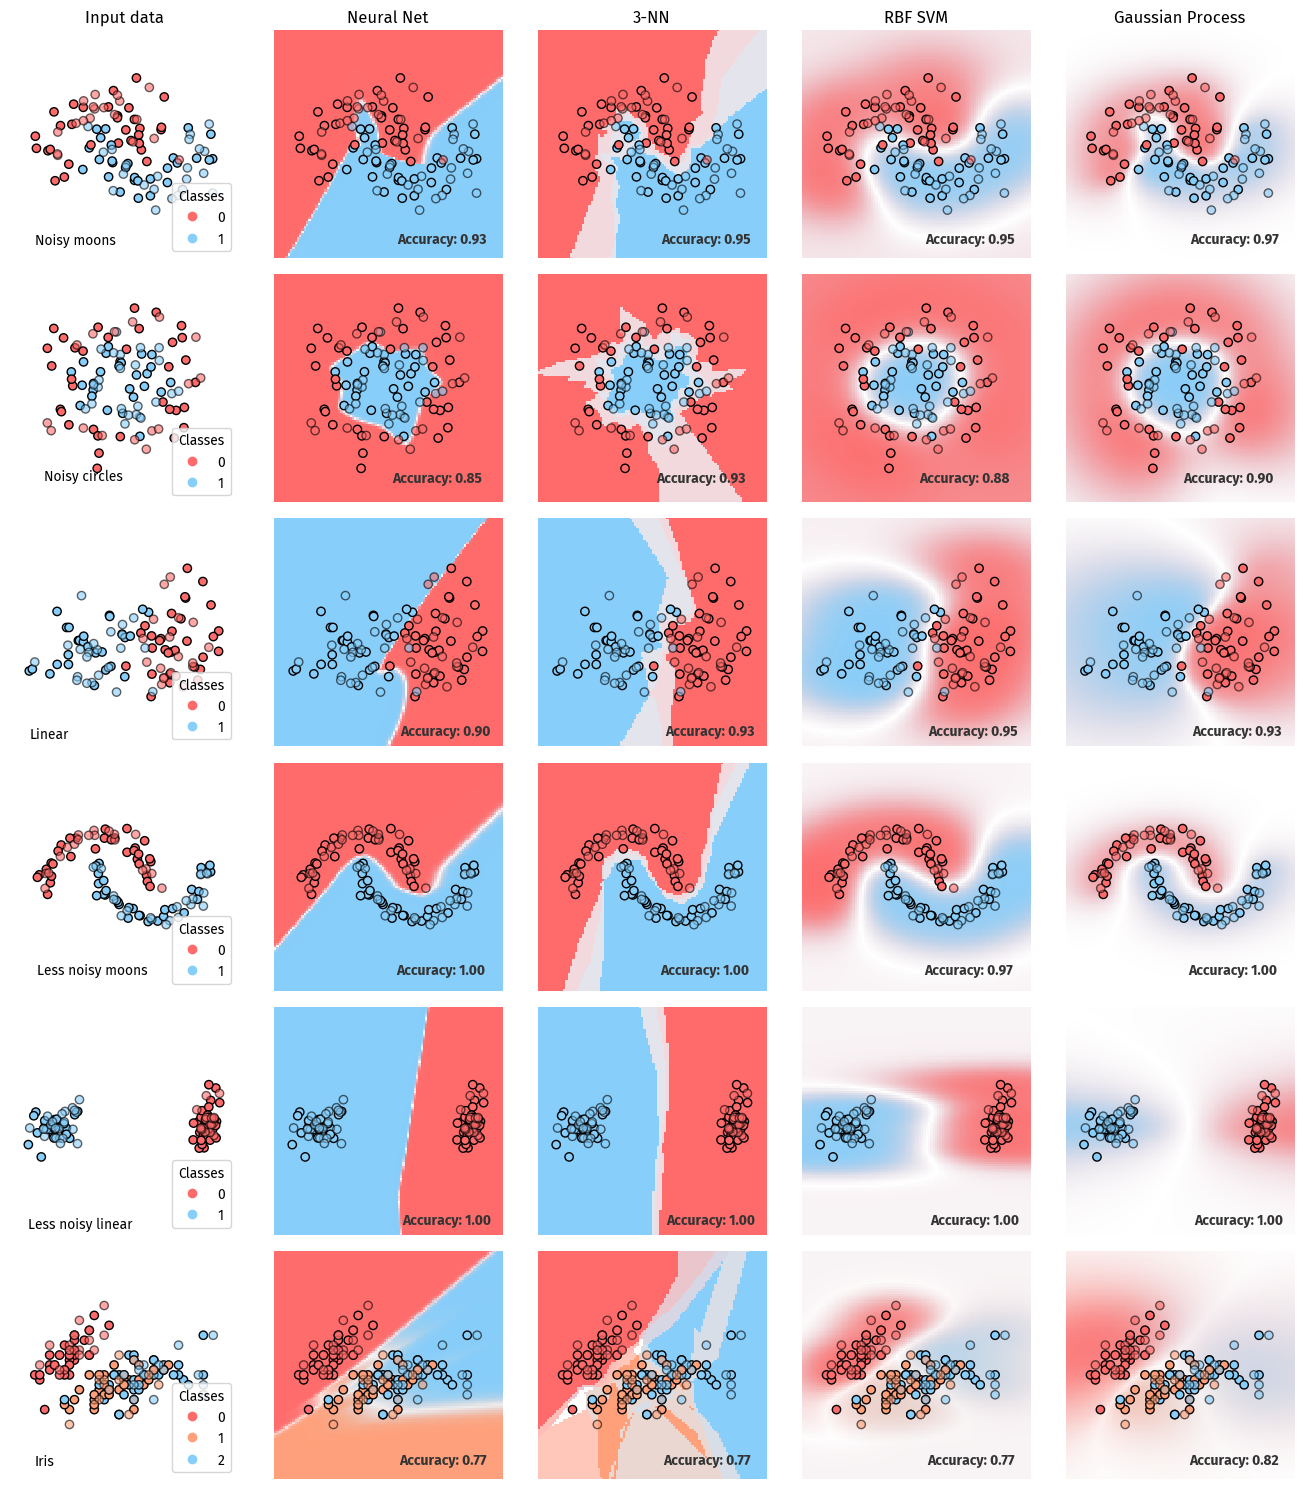

In [49]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
from functools import partial
from typing import TypeAlias, Any, Tuple, Callable, NamedTuple
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ArrayLike: TypeAlias = jnp.ndarray | np.ndarray

def to_numpy(x: ArrayLike) -> np.ndarray:
    return np.array(x)

def jax_to_numpy_method(func: Callable) -> Callable:
    return lambda *args, **kwargs: to_numpy(func(*args, **kwargs))

def create_optimizer(learning_rate: float = 0.01):
    return optax.adam(learning_rate)

@partial(jit, static_argnums=(0, 1, 2))
def update(loss_fn: Callable, decision_fn: Callable, optimizer: optax.GradientTransformation, 
           params: Any, opt_state: Any, X: ArrayLike, y: ArrayLike):
    def loss(params):
        return loss_fn(decision_fn, params, X, y)
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

def fit(init_params: Callable, loss_fn: Callable, decision_fn: Callable, 
        learning_rate: float, num_epochs: int, X: ArrayLike, y: ArrayLike) -> Tuple[Any, jnp.ndarray]:
    X, y = jnp.array(X), jnp.array(y)
    classes = jnp.unique(y)
    params = init_params(X.shape[1], len(classes))
    optimizer = create_optimizer(learning_rate)
    opt_state = optimizer.init(params)
    
    for _ in range(num_epochs):
        params, opt_state, _ = update(loss_fn, decision_fn, optimizer, params, opt_state, X, y)
    
    return params, classes

# MLP-specific functions
def init_mlp_params(n_features: int, n_classes: int, hidden_dim: int = 100) -> dict[str, ArrayLike]:
    key = jax.random.PRNGKey(0)
    return {
        'W1': jax.random.normal(key, (n_features, hidden_dim)) * jnp.sqrt(2.0 / n_features),
        'b1': jnp.zeros((hidden_dim,)),
        'W2': jax.random.normal(key, (hidden_dim, n_classes)) * jnp.sqrt(2.0 / hidden_dim),
        'b2': jnp.zeros((n_classes,))
    }

def mlp_loss(decision_fn: Callable, params: dict[str, ArrayLike], X: ArrayLike, y: ArrayLike) -> float:
    logits = decision_fn(params, X)
    y_onehot = jax.nn.one_hot(y, logits.shape[-1])
    return -jnp.mean(jnp.sum(y_onehot * jax.nn.log_softmax(logits), axis=1))

def mlp_decision_function(params: dict[str, ArrayLike], X: ArrayLike, activation: Callable = jax.nn.relu) -> ArrayLike:
    H = activation(jnp.dot(X, params['W1']) + params['b1'])
    return jnp.dot(H, params['W2']) + params['b2']

# Named tuple for the classifier
class JAXClassifier(NamedTuple):
    params: Any
    decision_fn: Callable
    fit_proto: Callable

    @jax_to_numpy_method
    def predict(self, X: ArrayLike) -> ArrayLike:
        return jnp.argmax(self.decision_fn(self.params, X), axis=1)

    @jax_to_numpy_method
    def predict_proba(self, X: ArrayLike) -> ArrayLike:
        return jax.nn.softmax(self.decision_fn(self.params, X))

    def score(self, X: ArrayLike, y: ArrayLike) -> float:
        return jnp.mean(self.predict(X) == y)

    def fit(self, X: ArrayLike, y: ArrayLike) -> 'JAXClassifier':
        params, classes_ = self.fit_proto(X, y)
        return self._replace(params=params)


# Wrapper function to create an MLP classifier
def create_mlp_classifier(hidden_dim: int = 100, activation: Callable = jax.nn.relu, 
                          learning_rate: float = 0.01, num_epochs: int = 2000) -> JAXClassifier:
    init_params = partial(init_mlp_params, hidden_dim=hidden_dim)
    decision_fn = partial(mlp_decision_function, activation=activation)
    
    return JAXClassifier(
        params=None,
        fit_proto=partial(fit, init_params, mlp_loss, decision_fn, learning_rate, num_epochs),
        decision_fn=decision_fn
    )

if __name__ == "__main__":
    from sklearn.datasets import make_moons, make_circles, make_classification, load_iris
    from sklearn.model_selection import train_test_split

    classifiers = {
        "Neural Net": create_mlp_classifier(hidden_dim=20),
        "3-NN": MultiClassWrapper(KNeighborsClassifier(n_neighbors=3)),
        "RBF SVM": MultiClassWrapper(make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))),
        "Gaussian Process": MultiClassWrapper(make_pipeline(StandardScaler(), GaussianProcessClassifier(1.0 * RBF(1.0), random_state=0))),
    }

    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, 
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [
        (*make_moons(n_samples=100, noise=0.3, random_state=0), "Noisy moons"),
        (*make_circles(n_samples=100, noise=0.2, factor=0.5, random_state=1), "Noisy circles"),
        (linearly_separable[0], linearly_separable[1], "Linear"),
        (*make_moons(n_samples=100, noise=0.1, random_state=0), "Less noisy moons"),
        (*make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, 
                             n_clusters_per_class=1, class_sep=2.0), "Less noisy linear"),
        (*load_iris(return_X_y=True), "Iris")
    ]

    fig = plot_classifier_comparison(classifiers, datasets)
    fig.savefig('classifier_comparison.png')
    print("Classifier comparison plot saved as 'classifier_comparison.png'")